# EDA Feature Extraction

#### Contents: 

1. Loading EDA data from csv file after recorded session 
2. How to pre-process the raw data?
3. Decomposition of EDA signals into its components (SCL & SCR)
4. Extracting features from processed data 
5. Plotting features


In [2]:
# Import necessary packages including pyEDA and Neurokit2

from pyEDA.main import * 
import read_eda_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import MinuteLocator, DateFormatter
import neurokit2 as nk
import datetime as dt

### Loading recorded data into a dataframe 

This step includes: 
- Inserting names of columns that you want to extract including the timestamps and the EDA signals 
- Calling read_eda_data function by passing the url and column names 
- The function will read the signals into a dataframe and convert the timestamps to datetime object
- Additional series will be added to dataframe denoting the time elapsed for easier plotting

In [3]:
# Function to load data from the csv 

# Include the names of columns containing timestamps and EDA signals
columns = ["Shimmer_B03E_Timestamp_Unix_CAL", "Shimmer_B03E_GSR_Skin_Conductance_CAL"]

# Provide the url of the file as well as the column names
# Returns a dataframe with timestamps, raw eda data and time elapsed in seconds 
df, seconds_elapsed = read_eda_data.read_eda_data('test_data.csv', columns)

df.head

<bound method NDFrame.head of                            timestamp  eda_data              time_elapsed
0      2021-09-22 18:42:12.774017024  1.038762                       NaT
1      2021-09-22 18:42:12.781829888  1.038762 0 days 00:00:00.007812864
2      2021-09-22 18:42:12.785736192  1.038762 0 days 00:00:00.011719168
3      2021-09-22 18:42:12.789642240  1.038762 0 days 00:00:00.015625216
4      2021-09-22 18:42:12.793548544  1.038762 0 days 00:00:00.019531520
...                              ...       ...                       ...
301211 2021-09-22 19:01:52.074798592  0.765235 0 days 00:19:39.300781568
301212 2021-09-22 19:01:52.078704896  0.767011 0 days 00:19:39.304687872
301213 2021-09-22 19:01:52.082611200  0.764347 0 days 00:19:39.308594176
301214 2021-09-22 19:01:52.086516992  0.760795 0 days 00:19:39.312499968
301215 2021-09-22 19:01:52.090423552  0.767455 0 days 00:19:39.316406528

[301216 rows x 3 columns]>

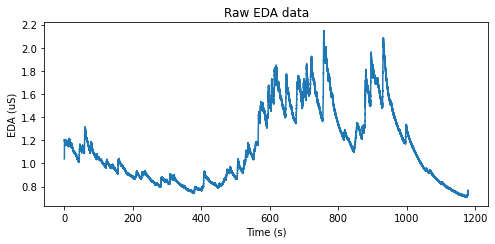

In [4]:
# Plotting raw data 

plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots()
ax.plot(seconds_elapsed, df.eda_data)
ax.set_title("Raw EDA data")
ax.set_xlabel("Time (s)")
ax.set_ylabel("EDA (uS)")

plt.show()

### Preprocessing Stage 

This step will include:

- Defining the sampling rate, desired new sampling rate and the cutoff frequence for the low pass filter
- These functions are called individually here to better explain the process
- There are options to use for convenient functions that will do all the preprocessing together (shown later)

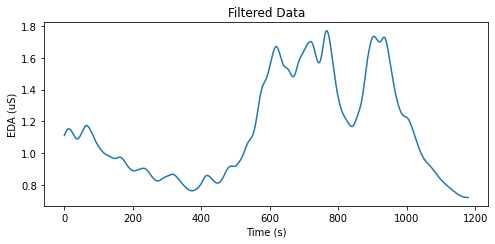

In [5]:
# Very important to update these values as per your recording! 
sampling_rate = 255
new_sampling_rate = 40
cutoff_freq = 5/sampling_rate

# Filtering data using a low pass filter 
filtered_data = butter_lowpassfilter(df.eda_data, cutoff_freq, sampling_rate)

# Plotting cleaned data 
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots()
ax.plot(seconds_elapsed, filtered_data)
ax.set_title('Filtered Data')
ax.set_xlabel('Time (s)')
ax.set_ylabel("EDA (uS)")

plt.show()

Text(0, 0.5, 'EDA (uS)')

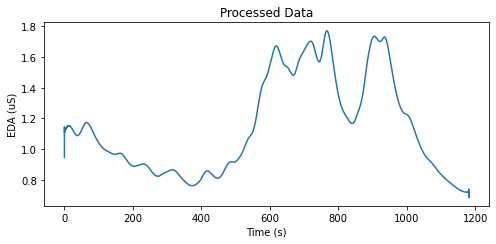

In [6]:
# Downsampling data obtained after filtering
downsampled_data = resample_data(filtered_data, sampling_rate, new_sampling_rate)
	
# Segmentwise the data based on window sizes
# Returns list containing segmented data to be analysed, dictionary objects to store temporary values like segment indices
s_working_data, s_measures, gsrdata_segmentwise = segmentwise(downsampled_data, sample_rate=new_sampling_rate, segment_width=60, segment_overlap=0)

# Using rolling mean funtion to perform a moving average across a 1-second window to smoothe data and reduce artifacts
preprocessed_gsr = []
for i in gsrdata_segmentwise:
	preprocessed_gsr.append(rolling_mean(i, 1./new_sampling_rate, new_sampling_rate))

# Plotting the processed signal
# Converting nested list to single list for easier plotting
preprocessed_list = []
for i in range(0, len(preprocessed_gsr)):
    for j in range(0, len(preprocessed_gsr[i])):
        preprocessed_list.append(preprocessed_gsr[i][j])

time_arr = np.linspace(0, len(preprocessed_list)/new_sampling_rate, len(preprocessed_list), endpoint=False)

plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots()
ax.plot(time_arr, preprocessed_list)
ax.set_title('Processed Data')
ax.set_xlabel('Time (s)')
ax.set_ylabel("EDA (uS)")


### Decomposing EDA into Tonic and Phasic Components 

- This step includes obtaining a dataframe containing EDA_Tonic, EDA_Phasic and EDA_Raw

<AxesSubplot:>

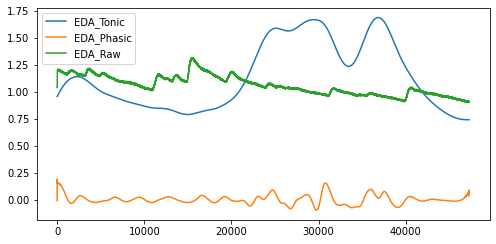

In [7]:
# Decomposition of EDA into Tonic and Phasic components

# Passing the pre-processed signals as a single list to eda_phasic function along with sampling rate
decomposed_signals = nk.eda_phasic(preprocessed_list, sampling_rate=255)

# Plotting Tonic and Phasic components along with raw data for comparision
decomposed_signals['EDA_Raw'] = df.eda_data
decomposed_signals.plot()


### Extracting Features 

In [8]:
# Feature extraction for the whole session

# Calculate the onset and offset of peaks by passing on the phasic component of signals 
# obtained from previous function. Returns a 2-d array of onsets and offsets 
onset_offset = calculate_onSetOffSet(decomposed_signals['EDA_Phasic'], sampling_rate)

# Obtain list of peaks (their amplitudes) and their respective indices
peaklist, indexlist = calculate_thepeaks(decomposed_signals['EDA_Phasic'], onset_offset)

# Obtain maximum amplitude of peaks
max_peak = calculate_max_peaks(peaklist)

# Obtain mean of gsr for whole session
mean_gsr = calculate_mean_gsr(preprocessed_list)

# Number of peaks in whole session
number_of_peaks = calculate_number_of_peaks(peaklist)


### Convenient Function to extract all statistical features 

In [9]:
# Function for feature extraction from segmented data

m, wd, eda_clean = process_statistical(df.eda_data, use_scipy=True, sample_rate=255, new_sample_rate=40, segment_width=60, segment_overlap=0)
'''
Returns:
m: dictionary containing 'segment_indices', 'number_of_peaks', 'mean_gsr', 'max_of_peaks'
wd: dictionary containing 'segment_indices', 'filtered_phasic_gsr', 'phasic_gsr', 'tonic_gsr', 'peaklist', 'indexlist'
eda_clean: nested list containing processed signals for each segment 

'''

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
     pcost       dcost       gap    pres   dres
 0: -1.5268e+03 -1.5245e+03  3e+03  5e+01  4e+00
 1: -1.5249e+03 -1.6100e+03  9e+01  2e+00  1e-01
 2: -1.5253e+03 -1.5292e+03  4e+00  4e-02  3e-03
 3: -1.5267e+03 -1.5273e+03  5e-01  4e-04  3e-05
 4: -1.5271e+03 -1.5272e+03  1e-01  5e-05  4e-06
 5: -1.5272e+03 -1.5272e+03  3e-02  7e-06  6e-07
 6: -1.5272e+03 -1.5272e+03  5e-03  5e-07  4e-08
 7: -1.5272e+03 -1.5272e+03  1e-03  3e-08  2e-09
 8: -1.5272e+03 -1.5272e+03  3e-04  4e-09  4e-10
 9: -1.5272e+03 -1.5272e+03  2e-04  2e-09  1e-10
10: -1.5272e+03 -1.5272e+03  6e-05  3e-10  3e-11
11: -1.5272e+03 -1.5272e+03  3e-05  7e-11  6e-12
12: -1.5272e+03 -1.5272e+03  8e-06  2e-11  1e-12
13: -1.5272e+03 -1.5272e+03  3e-06  3e-12  7e-13
14: -1.5272e+03 -1.5272e+03  6e-07  9e-13  1e-12
Optimal solution found.
     pcost       

"\nReturns:\nm: dictionary containing 'segment_indices', 'number_of_peaks', 'mean_gsr', 'max_of_peaks'\nwd: dictionary containing 'segment_indices', 'filtered_phasic_gsr', 'phasic_gsr', 'tonic_gsr', 'peaklist', 'indexlist'\neda_clean: nested list containing processed signals for each segment \n\n"

### Plotting Statistical features for segmented data

20


Text(0, 0.5, 'EDA (uS)')

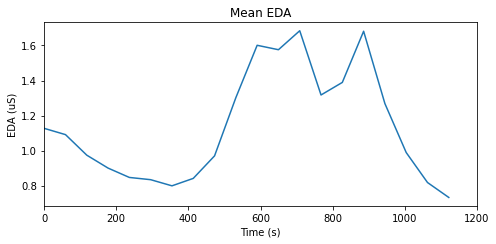

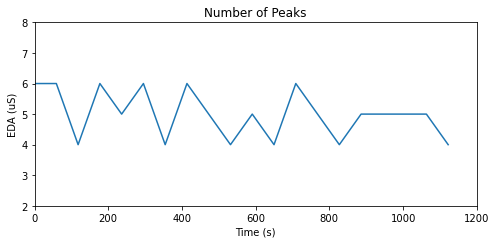

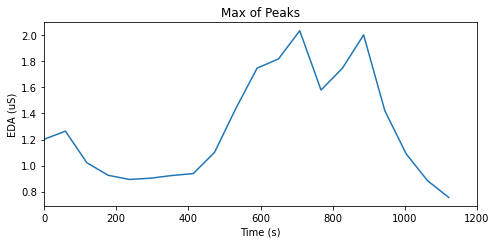

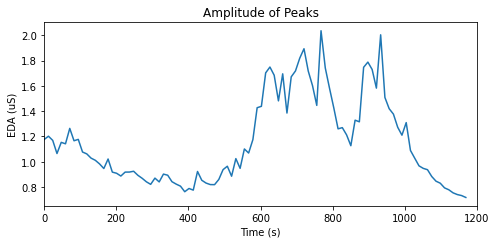

In [10]:
# Plotting statistical features for the segments 

# Creating single list for easy plotting
peaklist_list = []

for i in range(0, len(wd['peaklist'])):
    for j in range(0, len(wd['peaklist'][i])):
        peaklist_list.append(wd['peaklist'][i][j])

# Creating time vectors 
time_m = np.linspace(0.0, len(preprocessed_list)/new_sampling_rate, 
                len(m['mean_gsr']), endpoint=False)
time_wd = np.linspace(0.0, len(preprocessed_list)/new_sampling_rate, 
                len(peaklist_list), endpoint=False)

# Plotting mean_gsr for segments
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots()
ax.plot(time_m, m['mean_gsr'])
ax.set_xlim(0, 1200)
ax.set_title('Mean EDA')
ax.set_xlabel('Time (s)')
ax.set_ylabel("EDA (uS)")

# Plotting number_of_peaks for segments 
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots()
ax.plot(time_m, m['number_of_peaks'])
ax.set_title('Number of Peaks')
ax.set_xlim(0, 1200)
ax.set_ylim(2, 8)
ax.set_xlabel('Time (s)')
ax.set_ylabel("EDA (uS)")

# Plotting max_of_peaks for segments 
print(time_m.size)
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots()
ax.plot(time_m, m['max_of_peaks'])
ax.set_title('Max of Peaks')
ax.set_xlim(0, 1200)
ax.set_xlabel('Time (s)')
ax.set_ylabel("EDA (uS)")

# Plotting peaks' amplitude for segments 
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots()
ax.plot(time_wd, peaklist_list)
ax.set_title('Amplitude of Peaks')
ax.set_xlim(0, 1200)
ax.set_xlabel('Time (s)')
ax.set_ylabel("EDA (uS)")

### Plotting Onset, Peaks and Half-recovery time 

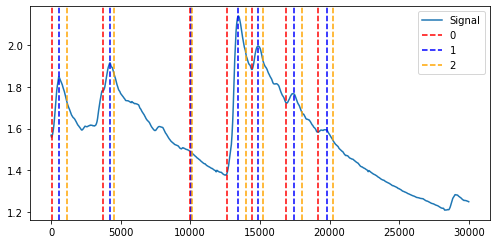

In [11]:
# Plotting onset, peaks and half-recovery time 

# Process the raw EDA signal
signals, info = nk.eda_process(df.iloc[180000:210000, 1], sampling_rate=255)
cleaned = signals["EDA_Clean"]
features = [info["SCR_Onsets"], info["SCR_Peaks"], info["SCR_Recovery"]]
# Visualize SCR features in cleaned EDA signal
plot = nk.events_plot(features, cleaned, color=['red', 'blue', 'orange'])

### Automatic Feature Extraction 

This step includes: 

1. Training the autoencoder using prepare_automatic function 
2. After our autoencoder is trained, we use the following function in order to extract automatic features from any GSR signal using process_automatic function.

NOTE: the size of gsr signals here should be equal to the size of GSR signals which the autoencoder were being trained by. (The same window size for entire study) If another window size is needed to be used, autoencoder needs to be retrained using new list of GSR signals with that size.

In [29]:
# Automatic Feature Extraction using pyEDA
prepare_automatic(gsrdata_segmentwise[0:19], sample_rate=255, new_sample_rate=255, k=32, epochs=100, batch_size=10)
automatic_features = process_automatic(gsrdata_segmentwise[0])
print(automatic_features)

If you are using this tool for your research please cite this paper: "pyEDA: An Open-Source Python Toolkit for Pre-processing and Feature Extraction of Electrodermal Activity"
Train data concatenated due to incompatible batch_size!
epoch : 1/100, loss = 1.076868
epoch : 2/100, loss = 0.139188
epoch : 3/100, loss = 0.384072
epoch : 4/100, loss = 0.360993
epoch : 5/100, loss = 0.154578
epoch : 6/100, loss = 0.196227
epoch : 7/100, loss = 0.226400
epoch : 8/100, loss = 0.141709
epoch : 9/100, loss = 0.062441
epoch : 10/100, loss = 0.069626
epoch : 11/100, loss = 0.113219
epoch : 12/100, loss = 0.104710
epoch : 13/100, loss = 0.061434
epoch : 14/100, loss = 0.036931
epoch : 15/100, loss = 0.044219
epoch : 16/100, loss = 0.062549
epoch : 17/100, loss = 0.070433
epoch : 18/100, loss = 0.062156
epoch : 19/100, loss = 0.045906
epoch : 20/100, loss = 0.034146
epoch : 21/100, loss = 0.033195
epoch : 22/100, loss = 0.038766
epoch : 23/100, loss = 0.042086
epoch : 24/100, loss = 0.040101
epoch : 2

### Performing event-related EDA analysis on epochs

Function returns:

- DataFrame – A dataframe containing the analyzed EDA features for each epoch, with each epoch indicated by the Label column (if not present, by the Index column). The analyzed features consist the following:

- EDA_SCR: indication of whether Skin Conductance Response (SCR) occurs following the event (1 if an SCR onset is present and 0 if absent) and if so, its corresponding peak amplitude, time of peak, rise and recovery time. If there is no occurrence of SCR, nans are displayed for the below features.

- EDA_Peak_Amplitude: the maximum amplitude of the phasic component of the signal.

- SCR_Peak_Amplitude: the peak amplitude of the first SCR in each epoch.

- SCR_Peak_Amplitude_Time: the timepoint of each first SCR peak amplitude.

- SCR_RiseTime: the risetime of each first SCR i.e., the time it takes for SCR to reach peak amplitude from onset.

- SCR_RecoveryTime: the half-recovery time of each first SCR i.e., the time it takes for SCR to decrease to half amplitude.

In [34]:
# Process the data
df, info = nk.bio_process(eda=data["EDA"], sampling_rate=100)
events = nk.events_find(data["Photosensor"], threshold_keep='below',
                        event_conditions=["Negative", "Neutral", "Neutral", "Negative"])
epochs = nk.epochs_create(df, events, sampling_rate=100, epochs_start=-0.1, epochs_end=6.9)

# Analyze
nk.eda_eventrelated(epochs) 

,Label,Condition,Event_Onset,EDA_Peak_Amplitude,EDA_SCR,SCR_Peak_Amplitude,SCR_Peak_Amplitude_Time,SCR_RiseTime,SCR_RecoveryTime
1,1,Negative,1024,1.995617,1,3.114808,4.716881,1.74,673.0
2,2,Neutral,4957,0.409627,0,NaN,NaN,NaN,NaN
3,3,Neutral,9224,0.023944,0,NaN,NaN,NaN,NaN
4,4,Negative,12984,1.056855,1,1.675922,2.844206,1.73,477.0
